## Clustering neighbourhoods in New York City

### Introduction

New York - the city that never sleeps. It is one the busiest cities, a hub for toursim and an economic powerhouse. Tourism of the city and state generated 19.3 billion dollars in tax revenues in 2019, with 9.1 billion dollars accruing to state and local governments. 

With tourism comes an additional source of revenue and a lot of spending power in the form of new visitors. An analysis of businesses and locations that generate this revenue from both locals and visitors could reveal new potential opportunites for specific categories of businesses to open up where they are likely to do well.

### The business problem
We attempt to analyse specific, popular venue types generated by the FourSquare API to find out which types of categories are popular amongst the people and find out which neighbourhoods or boroughs these venues would do well in. This would help investors and stakeholders make informed decisions on where a given type of venue would perform well. 

### Data and sourcing

Data for neighbourhoods within the city of New York was obtained from the NYC Open data in the form of a GEOJson file. We combine this data with aggregated information obtained from the FourSquare API to consturct a new dataframe that will consist of all relevant information. 

Since we're using an API to collect information based on location data for venues in a nighbourhood or borough, we created an account that allows for get requests to be made via the FourSquare website, this account and its credentials will be used to find any relevant information that would help us reach a conclusion at a later date. 

In summary, all data collected was obtained and sourced from both FourSquare and NYCOpenData.

### Methodology
This section illustrates and describes all methods and transformations used in our exploratory and modeling phase. The end goal is to group venues into clusters that would contain a trends on which venue is the most popular in a borough or neighbourhood, and what types of venues exist in that area. This clustering method should give us more than enough insight into what businesses would do well there, if opened. While it is possible to generate candidate locations, we have no method in place to cross reference if these locations are indeed available, or even exist in real time, and as a result, this part of the proposal will remain out of scope for the time being. 

In [1]:
import numpy as np 
import pandas as pd
import requests
from bs4 import BeautifulSoup
import folium
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# get NY neighbourhood data from geojson file
geospatial_ny = pd.read_json('Neighborhood Tabulation Areas (NTA).geojson')
geospatial_ny

,type,features
0,FeatureCollection,"{'type': 'Feature', 'properties': {'ntacode': ..."
1,FeatureCollection,"{'type': 'Feature', 'properties': {'ntacode': ..."
2,FeatureCollection,"{'type': 'Feature', 'properties': {'ntacode': ..."
3,FeatureCollection,"{'type': 'Feature', 'properties': {'ntacode': ..."
4,FeatureCollection,"{'type': 'Feature', 'properties': {'ntacode': ..."
...,...,...
190,FeatureCollection,"{'type': 'Feature', 'properties': {'ntacode': ..."
191,FeatureCollection,"{'type': 'Feature', 'properties': {'ntacode': ..."
192,FeatureCollection,"{'type': 'Feature', 'properties': {'ntacode': ..."
193,FeatureCollection,"{'type': 'Feature', 'properties': {'ntacode': ..."


In [3]:
geospatial_flat = pd.json_normalize(geospatial_ny['features'])

In [4]:
geospatial_flat

,type,properties.ntacode,properties.shape_area,properties.county_fips,properties.ntaname,properties.shape_leng,properties.boro_name,properties.boro_code,geometry.type,geometry.coordinates
0,Feature,BK88,54005019.3628,047,Borough Park,39247.2278068,Brooklyn,3,MultiPolygon,"[[[[-73.97604935591414, 40.631275905646646], [..."
1,Feature,QN51,52488277.668,081,Murray Hill,33266.9048424,Queens,4,MultiPolygon,"[[[[-73.80379022888246, 40.77561011179248], [-..."
2,Feature,QN27,19726845.7074,081,East Elmhurst,19816.7119065,Queens,4,MultiPolygon,"[[[[-73.8610972440186, 40.7636644770877], [-73..."
3,Feature,BK25,29991967.3333,047,Homecrest,27514.0225502,Brooklyn,3,MultiPolygon,"[[[[-73.95859278495766, 40.610403030935046], [..."
4,Feature,QN41,27774853.5522,081,Fresh Meadows-Utopia,22106.4312724,Queens,4,MultiPolygon,"[[[[-73.77757506882061, 40.73019327580701], [-..."
...,...,...,...,...,...,...,...,...,...,...
190,Feature,MN06,10734804.9237,061,Manhattanville,17357.2462524,Manhattan,1,MultiPolygon,"[[[[-73.94607828674226, 40.82126321606191], [-..."
191,Feature,MN13,37056588.0199,061,Hudson Yards-Chelsea-Flatiron-Union Square,45490.5807254,Manhattan,1,MultiPolygon,"[[[[-74.00178824088411, 40.76229451963905], [-..."
192,Feature,MN15,18373942.8129,061,Clinton,34570.7764204,Manhattan,1,MultiPolygon,"[[[[-73.99383108136989, 40.772931787348035], [..."
193,Feature,MN01,17771939.5903,061,Marble Hill-Inwood,31122.1260824,Manhattan,1,MultiPolygon,"[[[[-73.92234459307939, 40.85568233581442], [-..."


In [5]:
# syntax for geometry (retrieve latlong), this is in long lat format
print(geospatial_flat['geometry.coordinates'][0][0][0][0])
print(geospatial_flat['geometry.coordinates'][1][0][0][0])

[-73.97604935591414, 40.631275905646646]
[-73.80379022888246, 40.77561011179248]


In [6]:
# syntax for names, example
print(geospatial_flat['properties.boro_name'][0])
print(geospatial_flat['properties.ntaname'][0])

Brooklyn
Borough Park


In [7]:
# create a neighbourhood dataframe
neighbourhood_df = pd.DataFrame(columns=['Borough','Neighbourhood','Latitude','Longitude'])

borough_list = list(geospatial_flat['properties.boro_name'])
neighbourhood_list = list(geospatial_flat['properties.ntaname'])
full_coordinate_list = list(geospatial_flat['geometry.coordinates'])
lat_list = []
long_list = []

def extract(lst):
    return[i[0][0][0] for i in lst]

first_coordinate_list = extract(full_coordinate_list)
lat_list = [i[1] for i in first_coordinate_list]
long_list = [i[0] for i in first_coordinate_list]

In [8]:
# add all rows to dataframe
neighbourhood_df['Borough'] = borough_list
neighbourhood_df['Neighbourhood'] = neighbourhood_list
neighbourhood_df['Latitude'] = lat_list
neighbourhood_df['Longitude'] = long_list

In [9]:
neighbourhood_df

,Borough,Neighbourhood,Latitude,Longitude
0,Brooklyn,Borough Park,40.631276,-73.976049
1,Queens,Murray Hill,40.775610,-73.803790
2,Queens,East Elmhurst,40.763664,-73.861097
3,Brooklyn,Homecrest,40.610403,-73.958593
4,Queens,Fresh Meadows-Utopia,40.730193,-73.777575
...,...,...,...,...
190,Manhattan,Manhattanville,40.821263,-73.946078
191,Manhattan,Hudson Yards-Chelsea-Flatiron-Union Square,40.762295,-74.001788
192,Manhattan,Clinton,40.772932,-73.993831
193,Manhattan,Marble Hill-Inwood,40.855682,-73.922345


We have neighbourhood and borough data now. Now we'll get the coordinates of NYC.

In [10]:
from geopy.geocoders import Nominatim
address_query = 'New York City, NY, USA'

geolocator = Nominatim(user_agent = 'explorer')
location = geolocator.geocode(address_query)
latitude = location.latitude
longitude = location.longitude

print('City center coordinates of NY are: ', latitude, longitude)

City center coordinates of NY are:  40.7127281 -74.0060152


In [11]:
# look at map to check if correct
NY_map = folium.Map(location = [latitude,longitude], zoom_start=11)
folium.Marker(location=[latitude,longitude], popup="<strong> City Center </strong>", 
             icon=folium.Icon(color='red')).add_to(NY_map)
for la, lo, bo, nb, in zip(neighbourhood_df['Latitude'], neighbourhood_df['Longitude'],
                          neighbourhood_df['Borough'], neighbourhood_df['Neighbourhood']):
    label = '{}, {}'.format(nb, bo)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([la,lo], radius=4, popup=label, color='green', fill=True,
                       fill_color='green', fill_opacity=0.6, parse_html=False).add_to(NY_map)
    
NY_map
# Visualizing neighbourhood locations on the map

Okay, so we have the city center located directly on city hall, and each datapoint appears to include all the neighbourhoods and boroughs we obtained from the NYC Open data JSON file. 

Now we query the FS API to find locations around the city center within a given radius.

In [12]:
# specify credentials and limits
CLIENT_ID = 'OWXAELFT3MFWRNTIEXGRIKHVEVRLIQAES4JYUEE405H4JMOZ' 
CLIENT_SECRET = '4I45VCOCKPJR0TRU3FIZIL12TWLISVETYIEC1HAGLSCE0TBM' 
VERSION = '20180605' 
LIMIT = 150
RADIUS = 5000 # 5 km radius
ACCESS_TOKEN = 'N1DOPD4F2NGQFJQE45USGQHZQTGIQRFQ4NZEG1JFHS44YMIF'
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, latitude, longitude, RADIUS, LIMIT)

In [13]:
# retrieve venues close to each neighbourhood
# we will need to filter out venues not within the city, if needed
def retrievePOI(names, lat, long, radius=500):
    POI = []
    for name, la, lo in zip(names, lat, long):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, la, lo, radius, LIMIT)
        
        result = requests.get(url).json()['response']['groups'][0]['items']
        
        POI.append([(name, la, lo, v['venue']['name'],
                    v['venue']['categories'][0]['name']) for v in result])
    nearbyPOIs = pd.DataFrame([i for POI in POI for i in POI])
    nearbyPOIs.columns = ['Neighbourhood', 'Latitude','Longitude','Venue','Category']
    return(nearbyPOIs)

In [14]:
NY_venues = retrievePOI(neighbourhood_df['Neighbourhood'], neighbourhood_df['Latitude'],
                       neighbourhood_df['Longitude'])
NY_venues

,Neighbourhood,Latitude,Longitude,Venue,Category
0,Borough Park,40.631276,-73.976049,Mendelsohn's Pizza,Pizza Place
1,Borough Park,40.631276,-73.976049,Ocean Parkway Bike Path,Bike Trail
2,Borough Park,40.631276,-73.976049,Chase Bank,Bank
3,Borough Park,40.631276,-73.976049,Cafe K,Restaurant
4,Borough Park,40.631276,-73.976049,VIDEO RAMA,Video Store
...,...,...,...,...,...
5048,park-cemetery-etc-Manhattan,40.684491,-74.010928,Red Hook Terminal,Pier
5049,park-cemetery-etc-Manhattan,40.684491,-74.010928,Queen Mary 2,Boat or Ferry
5050,park-cemetery-etc-Manhattan,40.684491,-74.010928,The Yard Children’s Playground,Playground
5051,park-cemetery-etc-Manhattan,40.684491,-74.010928,Park Bagels,Bagel Shop


In [15]:
OHE_data = pd.get_dummies(NY_venues[['Category']], prefix='',prefix_sep='')
OHE_data['Neighbourhood'] = NY_venues['Neighbourhood']
OHE_data

,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio,Zoo,Zoo Exhibit,Neighbourhood
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Borough Park
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Borough Park
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Borough Park
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Borough Park
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Borough Park
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5048,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,park-cemetery-etc-Manhattan
5049,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,park-cemetery-etc-Manhattan
5050,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,park-cemetery-etc-Manhattan
5051,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,park-cemetery-etc-Manhattan


In [16]:
# get mean of each category, we will use this to cluster
groupby_mean = OHE_data.groupby('Neighbourhood').mean().reset_index()
groupby_mean

,Neighbourhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arepa Restaurant,Argentinian Restaurant,...,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Airport,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,Allerton-Pelham Gardens,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,Annadale-Huguenot-Prince's Bay-Eltingville,0.0,0.0,0.0,0.034483,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.034483,0.034483,0.0,0.0,0.0,0.0,0.0
3,Arden Heights,0.0,0.0,0.0,0.047619,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.047619,0.000000,0.0,0.0,0.0,0.0,0.0
4,Astoria,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,park-cemetery-etc-Bronx,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
188,park-cemetery-etc-Brooklyn,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
189,park-cemetery-etc-Manhattan,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
190,park-cemetery-etc-Queens,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [24]:
# now use above dataframe to return common venue types for each neighbourhood
def most_common(row, common=5):
    row_cats = row.iloc[1:]
    row_cats = row_cats.sort_values(ascending = False)
    return row_cats.index.values[0:common]

suffixes = ['st','nd','rd']
columns = ['Neighbourhood']

for x in np.arange(5):
    try:
        columns.append('{}{} Most common venue'.format(x+1, suffixes[x]))
    except:
        columns.append('{}th Most common venue'.format(x+1))
neighbourhood_venues = pd.DataFrame(columns=columns)
neighbourhood_venues['Neighbourhood'] = groupby_mean['Neighbourhood']

for y in np.arange(groupby_mean.shape[0]):
    neighbourhood_venues.iloc[y,1:] = most_common(groupby_mean.iloc[y,:],5)

In [25]:
neighbourhood_venues

,Neighbourhood,1st Most common venue,2nd Most common venue,3rd Most common venue,4th Most common venue,5th Most common venue
0,Airport,Discount Store,Seafood Restaurant,Furniture / Home Store,Pilates Studio,Pier
1,Allerton-Pelham Gardens,Caribbean Restaurant,Deli / Bodega,Pizza Place,Spa,Nail Salon
2,Annadale-Huguenot-Prince's Bay-Eltingville,Bagel Shop,Sandwich Place,Pizza Place,Ice Cream Shop,Discount Store
3,Arden Heights,Pizza Place,Diner,Discount Store,Pharmacy,Fast Food Restaurant
4,Astoria,Burger Joint,Italian Restaurant,Gym,Café,Chinese Restaurant
...,...,...,...,...,...,...
187,park-cemetery-etc-Bronx,Deli / Bodega,Chinese Restaurant,Park,Supermarket,Food
188,park-cemetery-etc-Brooklyn,Skate Park,Park,Bus Stop,Accessories Store,Pet Café
189,park-cemetery-etc-Manhattan,Pier,Boat or Ferry,Playground,Cruise Ship,Track
190,park-cemetery-etc-Queens,Beach,Burger Joint,Park,Bus Stop,Pizza Place


#### Supplementary visualization with Folium - Heatmaps

This subsection visualizes all locations within the NY area and adds a heatmap layer to show the density of the venues from the center of the city. The objective of this step is to give us some context and perhaps insight into the density of places of interest are in the city, and which neighbourhood they may belong to. 

In [44]:
# create lat long df for all locations
from folium.plugins import HeatMap
all_locations_coordinates = NY_venues[['Latitude','Longitude']]
all_locations_heatmap = [[row['Latitude'], row['Longitude']] for i, row in all_locations_coordinates.iterrows()]

# visualize density of locations with the neighbourhoods and boroughs within them
POIMap = folium.Map(location=[latitude,longitude], zoom_start=11)
folium.Circle([latitude, longitude], radius = 3000, fill=False, color='black').add_to(POIMap)
folium.Circle([latitude, longitude], radius = 6000, fill=False, color='black').add_to(POIMap)
folium.Circle([latitude, longitude], radius = 12000, fill=False, color='black').add_to(POIMap)
folium.Circle([latitude, longitude], radius = 24000, fill=False, color='black').add_to(POIMap)
HeatMap(all_locations_heatmap).add_to(POIMap)
folium.Marker(location=[latitude,longitude], popup="<strong> City Center </strong>", 
             icon=folium.Icon(color='blue')).add_to(POIMap)
for la, lo, bo, nb, in zip(neighbourhood_df['Latitude'], neighbourhood_df['Longitude'],
                          neighbourhood_df['Borough'], neighbourhood_df['Neighbourhood']):
    label = '{}, {}'.format(nb, bo)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([la,lo], radius=4, popup=label, color='green', fill=True,
                       fill_color='green', fill_opacity=0.6, parse_html=False).add_to(POIMap)

In [45]:
POIMap

From the heatmap, we note that NY - altogether is a relatively 'hot' zone for businesses and venues close to the city center. There are many venues located in close proximity to each other, on the same latitude and longitude, which makes it rather difficult to discern how many locations exist in the same zone. However, we now know that a majority of the locations we have fall within the Manhattan, Bronx, Queens, and Brooklyn areas. If we were to assign neighbourhoods to them, they would be:
- Brooklyn Heights, Cobble Hill, Borough Park, Ocean Parkway, Midwood, Bensonhurst : Brooklyn
- Park-Cemetary-ETC, Gramercy, East Village, Battery Park City : Manhattan
- Mount Hope, Claremont-Bathgate, University Heights, Morris Heights : Bronx
- Jackson Heights, Corona, Elmhurst, North Corona, East Elmhurst, Jamaica : Quuens

New York City and its surrounding boroughs make up a large area of landmass, the outer circle from the city center brings the radius to approximately 24 kilometers (48 kilometers in total). Most venues appear to lie within the 12 kilometer range from the city center, while only a small portion lie within just 3 kilometers from the center. 

### Applying K-means
#### The Elbow method
The point of this section is to figure out how many clusters, or ***k*** are optimal for the K-Means algorithm. We will use the elbow method using 2 metrics, the distortion score and the Calinski-Harabasz indices. The following visualizations should make why we choose these metrics to determine the optima clear.

In [26]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

D:\Anaconda\envs\MDL\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


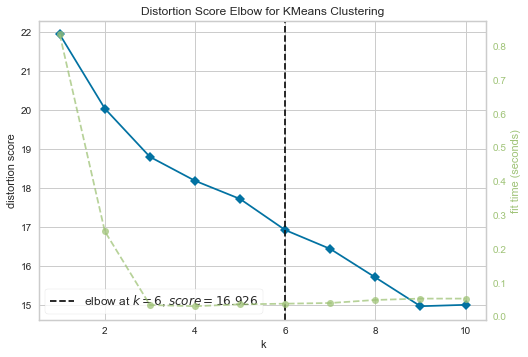

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [29]:
# new variable for clustering data
clustering_data = groupby_mean.drop('Neighbourhood', 1)

# init variable with default k-means model and fit to visualizer object for 1-10 clusters
k_optimal = KMeans(random_state=42)
visualizer = KElbowVisualizer(k_optimal, k=(1,11))

# fot data for distortion score elbow
visualizer.fit(clustering_data)
visualizer.show()

Distortion is at its minimum at 6 clusters (green line), and the last elbow is also at 6 clusters.

Trying CH index:

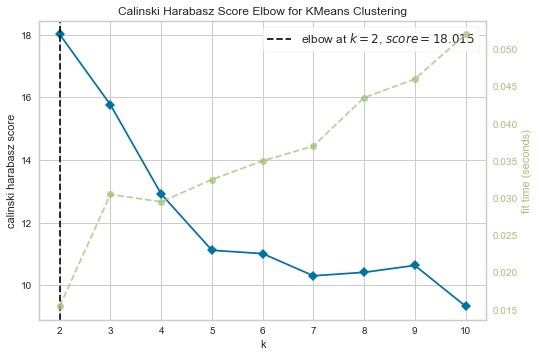

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [30]:
# fit model to visualize with CH index in metric parameter, note k is 2 to 11 to avoid an index error, see documentation
visualizer_CH = KElbowVisualizer(k_optimal, k=(2,11), metric='calinski_harabasz')
visualizer_CH.fit(clustering_data)
visualizer_CH.show()

CH index tells us that 2 clusters are best. The method *assumes* that the clusters are compact and well separated from each other, which may not be the case when we visualize them in terms of neighbourhoods or boroughs. See supplementary visualizations for additional information from the heatmaps.

We now know that there are 2 optimals according to our indices. If we want to cluster based on distortion, then 6 clusters is optimal. The CH index assumes that the clusters are well separated, so if we want to satisfy both the inter and intra cluster distances, then we use 2 clusters as the optimal. 

Since we want to only *cluster* locations, not predict where a location will belong, we will use 6 clusters and examine them for any trends or patterns. 

### Applying K-Means
#### The clustering model

In [46]:
# create and fit model with 6 clusters
model = KMeans(n_clusters=6, random_state=42).fit(clustering_data)

In [47]:
neighbourhood_venues.insert(0, 'Cluster labels', model.labels_)
result_df = neighbourhood_df
result_df = result_df.join(neighbourhood_venues.set_index('Neighbourhood'), on='Neighbourhood')

result_df

,Borough,Neighbourhood,Latitude,Longitude,Cluster labels,1st Most common venue,2nd Most common venue,3rd Most common venue,4th Most common venue,5th Most common venue
0,Brooklyn,Borough Park,40.631276,-73.976049,2.0,Restaurant,Bank,Bike Trail,Video Store,Pizza Place
1,Queens,Murray Hill,40.775610,-73.803790,2.0,Greek Restaurant,Gas Station,Coffee Shop,Bagel Shop,Pharmacy
2,Queens,East Elmhurst,40.763664,-73.861097,1.0,Coffee Shop,Lake,Donut Shop,Rental Car Location,Indie Movie Theater
3,Brooklyn,Homecrest,40.610403,-73.958593,2.0,Pizza Place,Bank,Pharmacy,Sushi Restaurant,Mobile Phone Shop
4,Queens,Fresh Meadows-Utopia,40.730193,-73.777575,2.0,Gym,Pizza Place,Tennis Court,Juice Bar,Fried Chicken Joint
...,...,...,...,...,...,...,...,...,...,...
190,Manhattan,Manhattanville,40.821263,-73.946078,1.0,Café,Mexican Restaurant,Coffee Shop,Pizza Place,Southern / Soul Food Restaurant
191,Manhattan,Hudson Yards-Chelsea-Flatiron-Union Square,40.762295,-74.001788,1.0,Gym,Italian Restaurant,Coffee Shop,Boat or Ferry,Food Court
192,Manhattan,Clinton,40.772932,-73.993831,1.0,Park,Pier,Art Gallery,Sculpture Garden,Athletics & Sports
193,Manhattan,Marble Hill-Inwood,40.855682,-73.922345,2.0,Baseball Field,Bus Station,Playground,Chinese Restaurant,Train Station


In [48]:
result_df.isnull().sum() / len(result_df)

Borough                  0.000000
Neighbourhood            0.000000
Latitude                 0.000000
Longitude                0.000000
Cluster labels           0.015385
1st Most common venue    0.015385
2nd Most common venue    0.015385
3rd Most common venue    0.015385
4th Most common venue    0.015385
5th Most common venue    0.015385
dtype: float64

In [49]:
# drop nulls
result_df_cleaned = result_df.dropna(subset=['Cluster labels'])
result_df_cleaned

# seems like just 3 records were removed

,Borough,Neighbourhood,Latitude,Longitude,Cluster labels,1st Most common venue,2nd Most common venue,3rd Most common venue,4th Most common venue,5th Most common venue
0,Brooklyn,Borough Park,40.631276,-73.976049,2.0,Restaurant,Bank,Bike Trail,Video Store,Pizza Place
1,Queens,Murray Hill,40.775610,-73.803790,2.0,Greek Restaurant,Gas Station,Coffee Shop,Bagel Shop,Pharmacy
2,Queens,East Elmhurst,40.763664,-73.861097,1.0,Coffee Shop,Lake,Donut Shop,Rental Car Location,Indie Movie Theater
3,Brooklyn,Homecrest,40.610403,-73.958593,2.0,Pizza Place,Bank,Pharmacy,Sushi Restaurant,Mobile Phone Shop
4,Queens,Fresh Meadows-Utopia,40.730193,-73.777575,2.0,Gym,Pizza Place,Tennis Court,Juice Bar,Fried Chicken Joint
...,...,...,...,...,...,...,...,...,...,...
190,Manhattan,Manhattanville,40.821263,-73.946078,1.0,Café,Mexican Restaurant,Coffee Shop,Pizza Place,Southern / Soul Food Restaurant
191,Manhattan,Hudson Yards-Chelsea-Flatiron-Union Square,40.762295,-74.001788,1.0,Gym,Italian Restaurant,Coffee Shop,Boat or Ferry,Food Court
192,Manhattan,Clinton,40.772932,-73.993831,1.0,Park,Pier,Art Gallery,Sculpture Garden,Athletics & Sports
193,Manhattan,Marble Hill-Inwood,40.855682,-73.922345,2.0,Baseball Field,Bus Station,Playground,Chinese Restaurant,Train Station


### Visualizing cluster results

In [50]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [51]:
cluster_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# set colour for clusters
z = np.arange(6)
c = [i + z + (i*z)**2 for i in range(6)]
colour_array = cm.rainbow(np.linspace(0,1,len(c)))
rainbow = [colors.rgb2hex(i) for i in colour_array]

# markers
marker_colours = []
for lat, lon, poi, clust in zip(result_df_cleaned['Latitude'], result_df_cleaned['Longitude'],
                               result_df_cleaned['Neighbourhood'], result_df_cleaned['Cluster labels']):
    lab = folium.Popup('Cluster ' + str(int(clust)+1) + '\n' + str(poi), parse_html=True)
    folium.CircleMarker([lat,lon], radius=5, popup=lab, color=rainbow[int(clust-1)],
                       fill=True, fill_color=rainbow[int(clust-1)]).add_to(cluster_map)
    
cluster_map

Lots of datapoints in Clusters 2 and 3, and a very sparse number of points in 1,6, and 4. Analysing the clusters by themselves in a tabular format might give us more insight. 

In [73]:
Cluster_1 = result_df_cleaned.loc[result_df_cleaned['Cluster labels'] == 0, result_df_cleaned.columns[[1]+list(range(2, result_df_cleaned.shape[1]))]]
Cluster_1

,Neighbourhood,Latitude,Longitude,Cluster labels,1st Most common venue,2nd Most common venue,3rd Most common venue,4th Most common venue,5th Most common venue
182,Mariner's Harbor-Arlington-Port Ivory-Granitev...,40.641448,-74.159456,0.0,Boat or Ferry,Accessories Store,Peruvian Restaurant,Pilates Studio,Pier


In [64]:
Cluster_2 = result_df_cleaned.loc[result_df_cleaned['Cluster labels'] == 1, result_df_cleaned.columns[[1]+list(range(2, result_df_cleaned.shape[1]))]]
Cluster_2

,Neighbourhood,Latitude,Longitude,Cluster labels,1st Most common venue,2nd Most common venue,3rd Most common venue,4th Most common venue,5th Most common venue
2,East Elmhurst,40.763664,-73.861097,1.0,Coffee Shop,Lake,Donut Shop,Rental Car Location,Indie Movie Theater
6,Clinton Hill,40.680641,-73.953370,1.0,Bar,Grocery Store,Caribbean Restaurant,Lounge,Seafood Restaurant
9,Queensbridge-Ravenswood-Long Island City,40.771177,-73.934527,1.0,Deli / Bodega,Restaurant,Italian Restaurant,Bus Stop,Street Art
12,Ocean Parkway South,40.625629,-73.970747,1.0,Convenience Store,Diner,Sushi Restaurant,Café,Soup Place
16,Bath Beach,40.594132,-74.002004,1.0,Burger Joint,Warehouse Store,Park,German Restaurant,Coffee Shop
...,...,...,...,...,...,...,...,...,...
189,Hamilton Heights,40.830458,-73.940346,1.0,Burger Joint,Donut Shop,Garden,Jazz Club,Bike Trail
190,Manhattanville,40.821263,-73.946078,1.0,Café,Mexican Restaurant,Coffee Shop,Pizza Place,Southern / Soul Food Restaurant
191,Hudson Yards-Chelsea-Flatiron-Union Square,40.762295,-74.001788,1.0,Gym,Italian Restaurant,Coffee Shop,Boat or Ferry,Food Court
192,Clinton,40.772932,-73.993831,1.0,Park,Pier,Art Gallery,Sculpture Garden,Athletics & Sports


In [67]:
Cluster_3 = result_df_cleaned.loc[result_df_cleaned['Cluster labels'] == 2, result_df_cleaned.columns[[1]+list(range(2, result_df_cleaned.shape[1]))]]
Cluster_3

,Neighbourhood,Latitude,Longitude,Cluster labels,1st Most common venue,2nd Most common venue,3rd Most common venue,4th Most common venue,5th Most common venue
0,Borough Park,40.631276,-73.976049,2.0,Restaurant,Bank,Bike Trail,Video Store,Pizza Place
1,Murray Hill,40.775610,-73.803790,2.0,Greek Restaurant,Gas Station,Coffee Shop,Bagel Shop,Pharmacy
3,Homecrest,40.610403,-73.958593,2.0,Pizza Place,Bank,Pharmacy,Sushi Restaurant,Mobile Phone Shop
4,Fresh Meadows-Utopia,40.730193,-73.777575,2.0,Gym,Pizza Place,Tennis Court,Juice Bar,Fried Chicken Joint
5,St. Albans,40.705228,-73.752051,2.0,Pizza Place,Latin American Restaurant,Donut Shop,Liquor Store,Deli / Bodega
...,...,...,...,...,...,...,...,...,...
184,Cypress Hills-City Line,40.679352,-73.863349,2.0,Pizza Place,Deli / Bodega,Shoe Store,Grocery Store,Clothing Store
186,East Concourse-Concourse Village,40.842756,-73.909587,2.0,Pizza Place,Supermarket,Pharmacy,Food Truck,Deli / Bodega
187,Washington Heights South,40.847428,-73.931394,2.0,Mobile Phone Shop,Food Truck,Bakery,Supplement Shop,Bank
188,West Concourse,40.843258,-73.911918,2.0,Pizza Place,Supermarket,Deli / Bodega,Pharmacy,Food Truck


In [68]:
Cluster_4 = result_df_cleaned.loc[result_df_cleaned['Cluster labels'] == 3, result_df_cleaned.columns[[1]+list(range(2, result_df_cleaned.shape[1]))]]
Cluster_4

,Neighbourhood,Latitude,Longitude,Cluster labels,1st Most common venue,2nd Most common venue,3rd Most common venue,4th Most common venue,5th Most common venue
50,Oakland Gardens,40.738482,-73.740170,3.0,Park,Pool,Accessories Store,Pet Café,Pilates Studio
78,Laurelton,40.685517,-73.733558,3.0,Park,Moving Target,Accessories Store,Pet Café,Pilates Studio
173,Lindenwood-Howard Beach,40.650279,-73.857223,3.0,Park,Accessories Store,Peruvian Restaurant,Pilates Studio,Pier


In [69]:
Cluster_5 = result_df_cleaned.loc[result_df_cleaned['Cluster labels'] == 4, result_df_cleaned.columns[[1]+list(range(2, result_df_cleaned.shape[1]))]]
Cluster_5

,Neighbourhood,Latitude,Longitude,Cluster labels,1st Most common venue,2nd Most common venue,3rd Most common venue,4th Most common venue,5th Most common venue
109,South Jamaica,40.699806,-73.773957,4.0,Bakery,Accessories Store,Planetarium,Pilates Studio,Pier


In [70]:
Cluster_6 = result_df_cleaned.loc[result_df_cleaned['Cluster labels'] == 5, result_df_cleaned.columns[[1]+list(range(2, result_df_cleaned.shape[1]))]]
Cluster_6

,Neighbourhood,Latitude,Longitude,Cluster labels,1st Most common venue,2nd Most common venue,3rd Most common venue,4th Most common venue,5th Most common venue
49,Far Rockaway-Bayswater,40.591440,-73.763762,5.0,Beach,Playground,School,Construction & Landscaping,Pet Service
117,New Dorp-Midland Beach,40.571478,-74.084691,5.0,Baseball Field,Beach,Skate Park,Playground,Soccer Field
138,park-cemetery-etc-Staten Island,40.550593,-74.118135,5.0,Ice Cream Shop,Beach,Accessories Store,Pet Café,Pilates Studio
185,park-cemetery-etc-Queens,40.570458,-73.865226,5.0,Beach,Burger Joint,Park,Bus Stop,Pizza Place


### Results / Discussion
There is a distinct pattern we can note from each of the clusters:
- Cluster 1 appears to contain locations based around maritime locations of interest, owing to piers and ferries nearby - the neighbourhood this cluster is located in is also a harbour. 
- Cluster 2 contains locations with a large number of 'restaurant' type locations and convenience stores. These are bars, coffee shops, delis and fast food locations. 
- Cluster 3 contains restaurants of different cuisines, supplmented by secondary locations such as shops of different types or financial installations. 
- Cluster 4 is small, containing primarily parks and small stores. 
- Cluster 5 contains just one datapont, which is a bakery, close to a store and a pier. 
- Cluster 6 contains outdoor locations and locations pertaining to sports, such as a baseball field, beach and playground. 

In the broader scope of the problem, if stakeholders are looking to capitalize on opening a location with high density, assuming a high density of shops brings in more patrons but increased competition, they would ideally want to look through available locations in the vicinity of the city center, approximately 3 to 12 kilometers in its radius. 
By a specific location type, the most common types are restaurants, pizza shops, coffee shops and cafes. Fast food locations also seem to rank highly in popularity. 
The city itself is diverse, but at the same time - it is much too cluttered and dense to provide an optimal experience of potential customers - deciding against opening a location near the city center may also save stakeholders the headaches of high rent / property prices - as well as space, which always an issue within a city. This decision however comes at the cost of reduced foot traffic, which may hinder revenue generation in the form of opportunity cost. 

### Conclusion
The purpose of this analysis was to primarily find a type of category that appears to be popular within New York city and its surrounding regions, such as Queens, Brooklyn and Manhattan. The FourSquare API returns a list of popular venues and their surrounding venues, which allowed us to narrow down which categories are the most popular in specific regions. 
We then clustered these venues by the neighbourhoods they belong to and serve, which then allows us to analyze how these locations are clustered and why. We noted that restaturants and shops are the most common. 
From the visualizations, we note that the densest areas with most of the locations are within 3 to 12 kilometers of the city center, which means the areas themselves have a high foot traffic and the most potential for revenue generation. 

With additional analysis from a cost and business perspective, stakeholders can decide on a category of venue, and a location they may want to consider opening the venue at based on potential revenue, and operating costs within or outside the city. 

### References
1. [Foursquare](https://foursquare.com)
2. [Geospatial Analysis basics](https://www.twilio.com/blog/2017/08/geospatial-analysis-python-geojson-geopandas.html)
3. [IBM Labs](https://www.coursera.org/learn/applied-data-science-capstone)